<a href="https://colab.research.google.com/github/alan713/alan1/blob/master/HW_3_q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

print(tf.__version__)


2.19.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0  # [0,1]
x_test  = x_test.astype("float32") / 255.0   # [0,1]

print(x_train.shape, x_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [3]:
BATCH_SIZE = 128

train_dataset_vae = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(BATCH_SIZE)
train_dataset_gan = tf.data.Dataset.from_tensor_slices(
    (x_train - 0.5) * 2.0  # for DCGAN: [-1, 1]
).shuffle(50000).batch(BATCH_SIZE, drop_remainder=True)


In [4]:
LATENT_DIM = 128

# ----- Encoder -----
encoder_inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)  # 16x16x32
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)              # 8x8x64
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# ----- Decoder -----
latent_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)  # 16x16x64
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 32x32x32
decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same", activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,134,016 (4.33 MB)

 Trainable params: 1,134,016 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,643 (2.23 MB)

 Trainable params: 584,643 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
vae_optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step_vae(x):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(x, training=True)
        recon = decoder(z, training=True)

        # Reconstruction loss (per image, then mean)
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x - recon), axis=(1, 2, 3))
        )

        # KL divergence term
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        total_loss = recon_loss + kl_loss

    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(total_loss, vars_)
    vae_optimizer.apply_gradients(zip(grads, vars_))

    return total_loss, recon_loss, kl_loss


In [6]:
EPOCHS_VAE = 20   # you can lower to 10 if needed

vae_total_losses = []
vae_recon_losses = []
vae_kl_losses = []
vae_epoch_times = []
vae_cum_times = []

for epoch in range(EPOCHS_VAE):
    start = time.time()
    epoch_total = tf.keras.metrics.Mean()
    epoch_recon = tf.keras.metrics.Mean()
    epoch_kl = tf.keras.metrics.Mean()

    for batch in train_dataset_vae:
        total_loss, recon_loss, kl_loss = train_step_vae(batch)
        epoch_total.update_state(total_loss)
        epoch_recon.update_state(recon_loss)
        epoch_kl.update_state(kl_loss)

    t = time.time() - start
    vae_epoch_times.append(t)
    vae_cum_times.append(sum(vae_epoch_times))
    vae_total_losses.append(epoch_total.result().numpy())
    vae_recon_losses.append(epoch_recon.result().numpy())
    vae_kl_losses.append(epoch_kl.result().numpy())

    print(f"VAE Epoch {epoch+1}/{EPOCHS_VAE} - "
          f"total_loss={epoch_total.result():.4f}, "
          f"recon={epoch_recon.result():.4f}, kl={epoch_kl.result():.4f}, "
          f"time={t:.2f}s")


VAE Epoch 1/20 - total_loss=141.7693, recon=133.5531, kl=8.2162, time=10.04s
VAE Epoch 2/20 - total_loss=108.9085, recon=94.4089, kl=14.4996, time=3.65s
VAE Epoch 3/20 - total_loss=95.1743, recon=79.3325, kl=15.8418, time=3.67s
VAE Epoch 4/20 - total_loss=87.8400, recon=71.9819, kl=15.8581, time=3.70s
VAE Epoch 5/20 - total_loss=84.9498, recon=68.7686, kl=16.1811, time=3.69s
VAE Epoch 6/20 - total_loss=83.6883, recon=67.2827, kl=16.4056, time=3.62s
VAE Epoch 7/20 - total_loss=82.4799, recon=65.6986, kl=16.7813, time=3.68s
VAE Epoch 8/20 - total_loss=81.2725, recon=64.2399, kl=17.0326, time=3.66s
VAE Epoch 9/20 - total_loss=80.6604, recon=63.5826, kl=17.0778, time=3.64s
VAE Epoch 10/20 - total_loss=80.1265, recon=62.9313, kl=17.1951, time=3.66s
VAE Epoch 11/20 - total_loss=79.6980, recon=62.4134, kl=17.2845, time=3.61s
VAE Epoch 12/20 - total_loss=79.3319, recon=61.9736, kl=17.3582, time=3.59s
VAE Epoch 13/20 - total_loss=79.0866, recon=61.6735, kl=17.4131, time=3.64s
VAE Epoch 14/20 - 

In [7]:
# Take N test images
N_SAMPLES = 100
x_ref_vae = x_test[:N_SAMPLES]

# Reconstructions
z_mean, z_log_var, z = encoder(x_ref_vae, training=False)
x_recon_vae = decoder(z, training=False).numpy()  # [0,1]

# Compute MSE & SSIM per image
mse_vae = []
ssim_vae = []

for i in range(N_SAMPLES):
    gt = x_ref_vae[i:i+1]           # (1,32,32,3)
    rec = x_recon_vae[i:i+1]

    mse_i = np.mean((gt - rec) ** 2)
    ssim_i = tf.image.ssim(gt, rec, max_val=1.0)[0].numpy()

    mse_vae.append(float(mse_i))
    ssim_vae.append(float(ssim_i))

print("VAE mean MSE:", np.mean(mse_vae))
print("VAE mean SSIM:", np.mean(ssim_vae))


VAE mean MSE: 0.01966207180172205
VAE mean SSIM: 0.33231149286031725


In [8]:
NOISE_DIM = 100

# ----- Generator -----
def make_generator():
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Dense(8 * 8 * 128, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 128)))  # 8x8x128

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())           # 16x16x64

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())           # 32x32x32

    model.add(layers.Conv2DTranspose(3, 3, strides=1, padding="same", use_bias=False,
                                     activation="tanh"))  # 32x32x3 in [-1,1]
    return model

# ----- Discriminator -----
def make_discriminator():
    model = tf.keras.Sequential(name="discriminator")
    model.add(layers.Conv2D(64, 3, strides=2, padding="same",
                            input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # logits
    return model

generator = make_generator()
discriminator = make_discriminator()
generator.summary()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 3)      │           864 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,056 (3.88 MB)

 Trainable params: 1,000,480 (3.82 MB)

 Non-trainable params: 16,576 (64.75 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [10]:
@tf.function
def train_step_gan(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [11]:
EPOCHS_GAN = 30  # reduce to 15 if slow

gan_gen_losses = []
gan_disc_losses = []
gan_epoch_times = []
gan_cum_times = []

for epoch in range(EPOCHS_GAN):
    start = time.time()
    gen_loss_metric = tf.keras.metrics.Mean()
    disc_loss_metric = tf.keras.metrics.Mean()

    for image_batch in train_dataset_gan:
        g_loss, d_loss = train_step_gan(image_batch)
        gen_loss_metric.update_state(g_loss)
        disc_loss_metric.update_state(d_loss)

    t = time.time() - start
    gan_epoch_times.append(t)
    gan_cum_times.append(sum(gan_epoch_times))
    gan_gen_losses.append(gen_loss_metric.result().numpy())
    gan_disc_losses.append(disc_loss_metric.result().numpy())

    print(f"GAN Epoch {epoch+1}/{EPOCHS_GAN} - "
          f"G_loss={gen_loss_metric.result():.4f}, "
          f"D_loss={disc_loss_metric.result():.4f}, "
          f"time={t:.2f}s")


GAN Epoch 1/30 - G_loss=0.9886, D_loss=1.1207, time=8.37s
GAN Epoch 2/30 - G_loss=0.7682, D_loss=1.3157, time=3.90s
GAN Epoch 3/30 - G_loss=0.7367, D_loss=1.3691, time=3.93s
GAN Epoch 4/30 - G_loss=0.6946, D_loss=1.3986, time=3.90s
GAN Epoch 5/30 - G_loss=0.7016, D_loss=1.3941, time=3.94s
GAN Epoch 6/30 - G_loss=0.7014, D_loss=1.3846, time=3.92s
GAN Epoch 7/30 - G_loss=0.7117, D_loss=1.3665, time=3.92s
GAN Epoch 8/30 - G_loss=0.7217, D_loss=1.3621, time=3.91s
GAN Epoch 9/30 - G_loss=0.7472, D_loss=1.3380, time=3.92s
GAN Epoch 10/30 - G_loss=0.7334, D_loss=1.3450, time=3.97s
GAN Epoch 11/30 - G_loss=0.7889, D_loss=1.2873, time=3.89s
GAN Epoch 12/30 - G_loss=0.7803, D_loss=1.2947, time=3.94s
GAN Epoch 13/30 - G_loss=0.7976, D_loss=1.2929, time=3.99s
GAN Epoch 14/30 - G_loss=0.7548, D_loss=1.3227, time=3.85s
GAN Epoch 15/30 - G_loss=0.8136, D_loss=1.2669, time=3.84s
GAN Epoch 16/30 - G_loss=0.8099, D_loss=1.2761, time=3.91s
GAN Epoch 17/30 - G_loss=0.7968, D_loss=1.2804, time=3.83s
GAN Ep

In [12]:
N_SAMPLES = 100

# Generate from noise
noise = tf.random.normal([N_SAMPLES, NOISE_DIM])
gen_images = generator(noise, training=False)   # [-1,1]
gen_images = (gen_images + 1.0) / 2.0          # [0,1]

# Reference real images (just take first N from test set)
x_ref_gan = x_test[:N_SAMPLES]

mse_gan = []
ssim_gan = []

for i in range(N_SAMPLES):
    gt = x_ref_gan[i:i+1]
    gi = gen_images[i:i+1]

    mse_i = np.mean((gt - gi.numpy()) ** 2)
    ssim_i = tf.image.ssim(gt, gi, max_val=1.0)[0].numpy()

    mse_gan.append(float(mse_i))
    ssim_gan.append(float(ssim_i))

print("GAN mean MSE:", np.mean(mse_gan))
print("GAN mean SSIM:", np.mean(ssim_gan))


GAN mean MSE: 0.11770772125571966
GAN mean SSIM: 0.052916307924315335


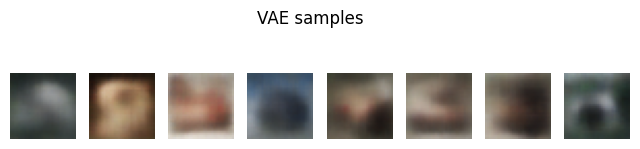

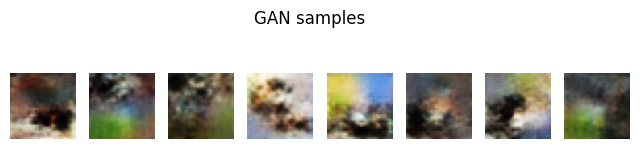

In [13]:
def show_generated(title, images):
    n = 8
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# VAE random samples
z_random = tf.random.normal([8, LATENT_DIM])
vae_samples = decoder(z_random, training=False).numpy()
show_generated("VAE samples", vae_samples)

# DCGAN random samples
noise = tf.random.normal([8, NOISE_DIM])
gan_samples = generator(noise, training=False)
gan_samples = (gan_samples + 1.0) / 2.0
show_generated("GAN samples", gan_samples.numpy())


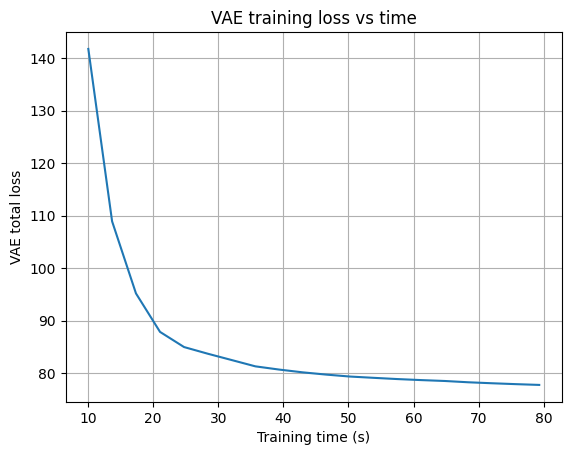

In [14]:
plt.figure()
plt.plot(vae_cum_times, vae_total_losses)
plt.xlabel("Training time (s)")
plt.ylabel("VAE total loss")
plt.title("VAE training loss vs time")
plt.grid(True)
plt.show()


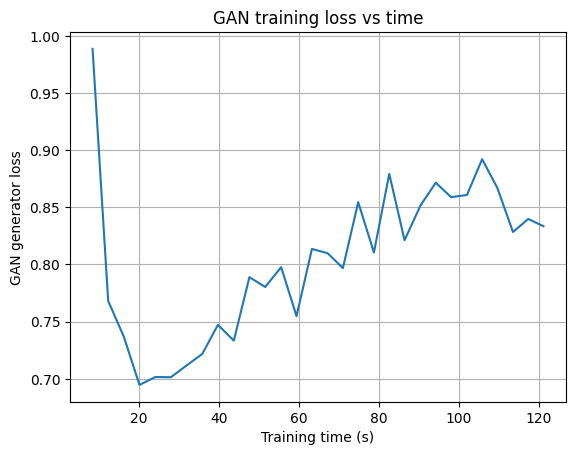

In [15]:
plt.figure()
plt.plot(gan_cum_times, gan_gen_losses)
plt.xlabel("Training time (s)")
plt.ylabel("GAN generator loss")
plt.title("GAN training loss vs time")
plt.grid(True)
plt.show()


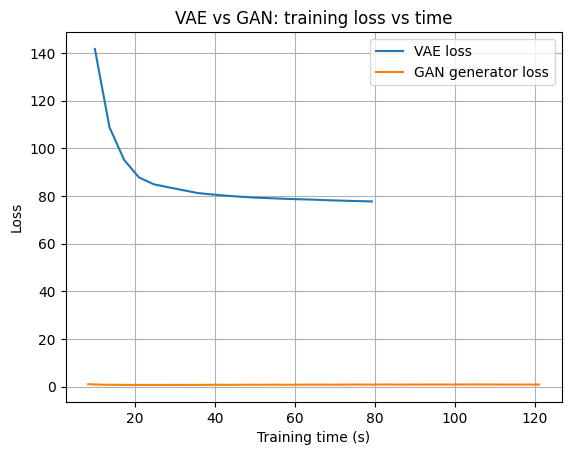

In [16]:
plt.figure()
plt.plot(vae_cum_times, vae_total_losses, label="VAE loss")
plt.plot(gan_cum_times, gan_gen_losses, label="GAN generator loss")
plt.xlabel("Training time (s)")
plt.ylabel("Loss")
plt.title("VAE vs GAN: training loss vs time")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
print("GAN mean MSE:", np.mean(mse_gan))
print("GAN mean SSIM:", np.mean(ssim_gan))


GAN mean MSE: 0.11770772125571966
GAN mean SSIM: 0.052916307924315335


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_row_of_images(images, title=None):
    """
    images: numpy array or tensor of shape (N, H, W, 3) with values in [0,1]
    """
    images = np.clip(images, 0.0, 1.0)
    n = images.shape[0]
    plt.figure(figsize=(2*n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


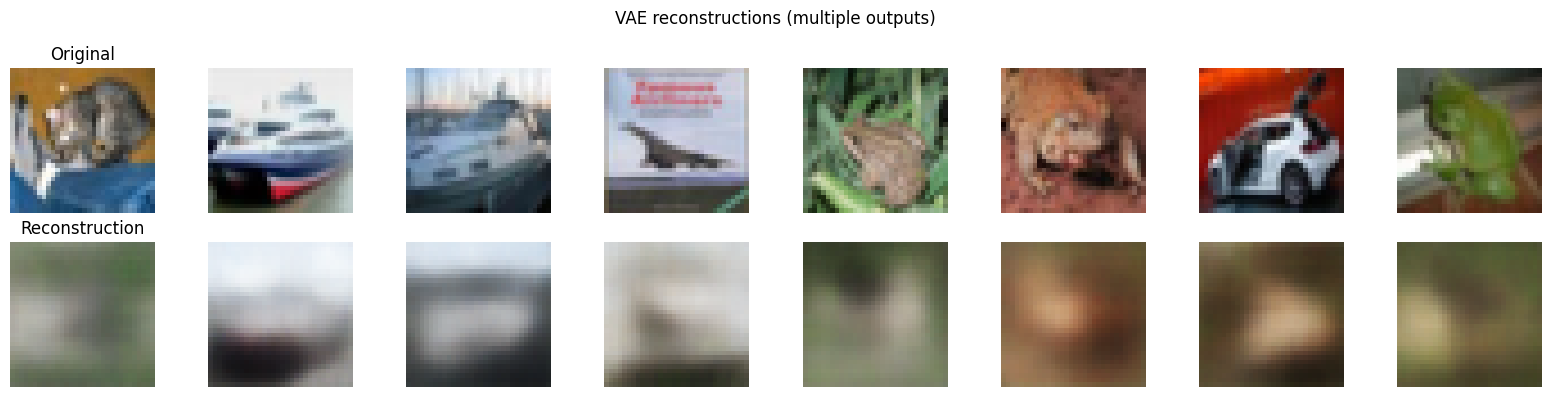

In [19]:
# Number of examples to show
n = 8

# Take first n images from the test set
x_ref = x_test[:n]  # (n, 32, 32, 3)

# Encode and decode with VAE
z_mean, z_log_var, z = encoder(x_ref, training=False)
x_recon = decoder(z, training=False).numpy()  # (n, 32, 32, 3)

# Show originals in one row, reconstructions in another
plt.figure(figsize=(2*n, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_ref[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_recon[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstruction")

plt.suptitle("VAE reconstructions (multiple outputs)")
plt.tight_layout()
plt.show()


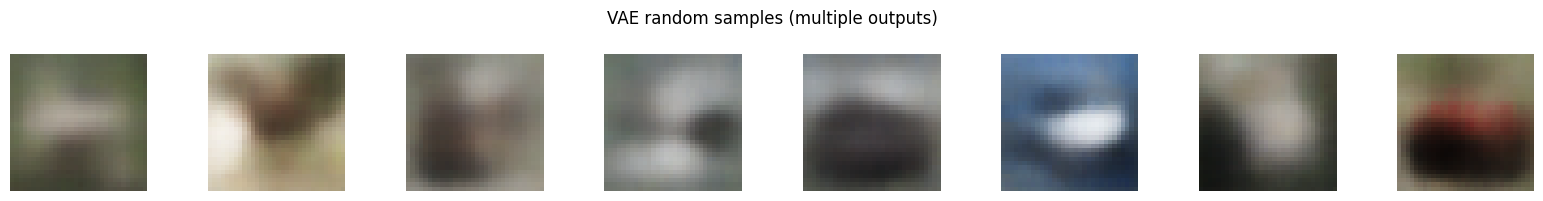

In [20]:
n = 8  # how many random samples to show

# Sample latent vectors from N(0, I)
z_random = tf.random.normal([n, LATENT_DIM])

# Decode to images in [0,1]
vae_samples = decoder(z_random, training=False).numpy()

# Show them
show_row_of_images(vae_samples, title="VAE random samples (multiple outputs)")


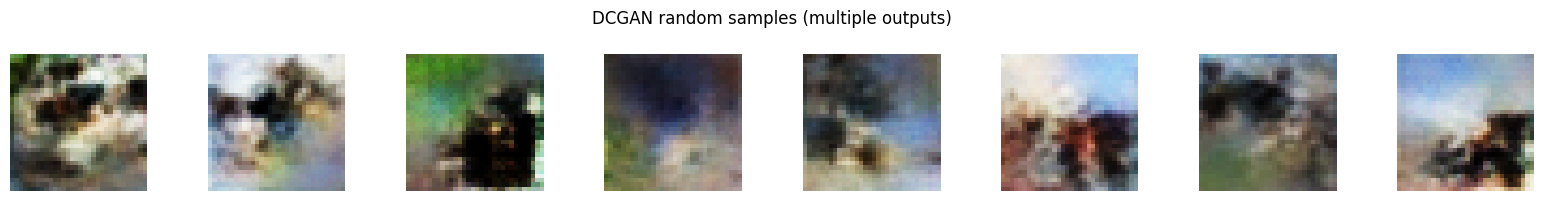

In [21]:
n = 8  # how many GAN samples to show

# Sample random noise
noise = tf.random.normal([n, NOISE_DIM])

# Generate images in [-1,1]
gan_samples = generator(noise, training=False)

# Map back to [0,1]
gan_samples = (gan_samples + 1.0) / 2.0
gan_samples = gan_samples.numpy()

# Show them
show_row_of_images(gan_samples, title="DCGAN random samples (multiple outputs)")
